# WRINKLE DETECTION

IMPORTING NECESSARY MODULES

In [3]:
import tensorflow as tf
import cv2
from random import *
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam,Adagrad,Adadelta,Adamax,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint


EXTRACT DATA FROM DATASET 

In [4]:
fldr="/kaggle/input/utkface-new/UTKFace"

In [5]:
import os
files=os.listdir(fldr)

DEFINE A BINARY LABEL THRESHOLD (AGE) FOR WRINKLE DETECTION

In [6]:
wrinkle_threshold = 40

STORING IMAGES AND LABELS

In [7]:
isWrinkle=[]
# genders=[]
images=[]
ctr = 1
for fle in files:
    age=int(fle.split('_')[0])
    
    if age > wrinkle_threshold:
        isWrinkle.append(1)                  # 1 - Wrinkled
    else:
        isWrinkle.append(0)                  # 0 - No Wrinkles
    
    #gender=int(fle.split('_')[1])
    #ages.append(age)
    #genders.append(gender)
    total=fldr+'/'+fle
    ctr += 1
    image=cv2.imread(total)

    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(48,48))
    images.append(image)

SAVING IMAGES, ISWRINKLE AS ARRAY

In [8]:
images_f=np.array(images)
isWrinkle_f=np.array(isWrinkle)

CREATING ANOTHER LIST OF IMAGES FROM EXISTING ONE FOR BETTER LEARNING

In [9]:
images_f_2=images_f/255
images_f_2.shape

(23708, 48, 48, 3)

SPLITTING THE DATASET INTO TEST AND TRAIN

In [10]:
x_train,x_test,y_train,y_test = train_test_split(images_f_2,isWrinkle_f,test_size=0.25, shuffle=False)

DEFINING THE MODEL

In [11]:
def Convolution(input_tensor,filters):
    x=Conv2D(filters=filters,kernel_size=(3,3),padding="same",strides=(1,1),kernel_regularizer=l2(0.001))(input_tensor)
    x = BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.1)(x)
    
    return x

In [12]:
def model(input_shape):
    inputs=Input((input_shape))
    conv_1=Convolution(inputs,32)
    maxp_1=MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2=Convolution(maxp_1,64)
    maxp_2=MaxPooling2D(pool_size=(2,2))(conv_2)
    conv_3=Convolution(maxp_2,128)
    maxp_3=MaxPooling2D(pool_size=(2,2))(conv_3)
    conv_4=Convolution(maxp_3,256)
    maxp_4=MaxPooling2D(pool_size=(2,2))(conv_4)
    flatten= Flatten()(maxp_4)
    dense_1=Dense(64,activation='relu')(flatten)
    dense_2=Dense(64,activation='relu')(flatten)
    drop_1=Dropout(0.2)(dense_1)
    drop_2=Dropout(0.2)(dense_2)
    output_1=Dense(1,activation='sigmoid',name='sex_out')(drop_1)
    output_2=Dense(1,activation='relu',name='age_out')(drop_2)
    model=Model(inputs=[inputs],outputs=[output_1,output_2])
    model.compile(loss=["binary_crossentropy","mae"],optimizer="Adam",metrics=["accuracy"])
    return model

In [13]:
model=model((48,48,3))

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 48, 48, 32)   0           ['batch_normalization[0][0]']

INITIALIZING THE MODEL

In [15]:
fle_s='Wrinkle_Detection.h5'
checkpoint=ModelCheckpoint(fle_s,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=75,monitor='val_loss',restore_best_weights='True')
callback_list=[checkpoint,Early_stop]

RUNNING THE MODEL

In [16]:
history=model.fit(
    x = x_train,
    y = y_train,
    batch_size=64,
    validation_data=(x_test,y_test),
    epochs=100,
    callbacks=callback_list
)

Epoch 1/100


2023-08-21 14:52:39.282401: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


278/278 [==============================] - ETA: 0s - loss: 1.0280 - sex_out_loss: 0.4776 - age_out_loss: 0.2831 - sex_out_accuracy: 0.7728 - age_out_accuracy: 0.7169
Epoch 1: val_loss improved from inf to 1.03608, saving model to Wrinkle_Detection.h5
278/278 [==============================] - 20s 22ms/step - loss: 1.0280 - sex_out_loss: 0.4776 - age_out_loss: 0.2831 - sex_out_accuracy: 0.7728 - age_out_accuracy: 0.7169 - val_loss: 1.0361 - val_sex_out_loss: 0.5403 - val_age_out_loss: 0.2845 - val_sex_out_accuracy: 0.7613 - val_age_out_accuracy: 0.7155
Epoch 2/100
276/278 [============================>.] - ETA: 0s - loss: 0.8189 - sex_out_loss: 0.3653 - age_out_loss: 0.2822 - sex_out_accuracy: 0.8384 - age_out_accuracy: 0.7178
Epoch 2: val_loss did not improve from 1.03608
278/278 [==============================] - 5s 17ms/step - loss: 0.8189 - sex_out_loss: 0.3654 - age_out_loss: 0.2824 - sex_out_accuracy: 0.8381 - age_out_accuracy: 0.7176 - val_loss: 1.0498 - val_sex_out_loss: 0.6264 

In [17]:
model.evaluate(x_test,y_test)

186/186 [==============================] - 1s 5ms/step - loss: 0.6689 - sex_out_loss: 0.2898 - age_out_loss: 0.2845 - sex_out_accuracy: 0.8709 - age_out_accuracy: 0.7155


[0.6689291000366211,
 0.28981542587280273,
 0.2844609320163727,
 0.8709296584129333,
 0.7155390381813049]

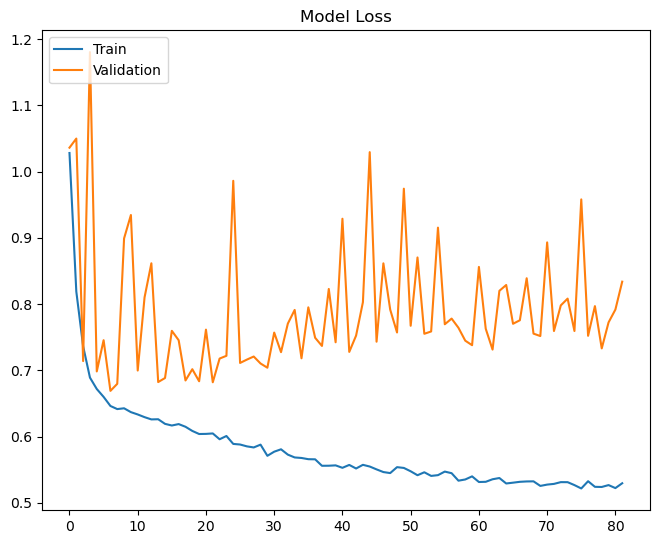

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel=('Epoch')
plt.ylabel=('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)

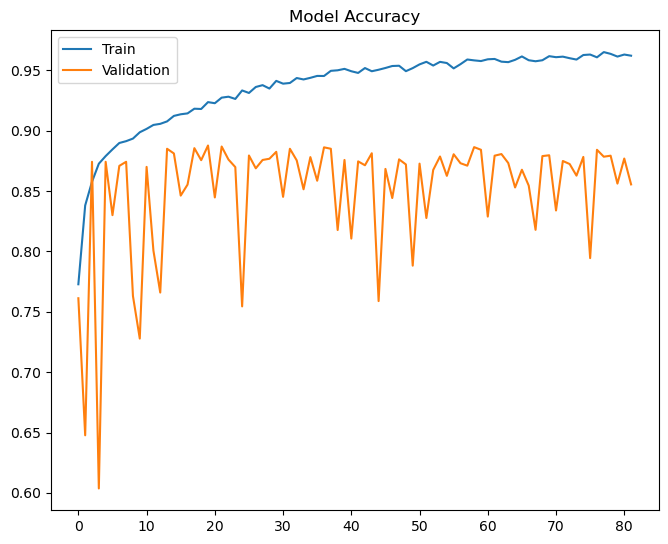

In [22]:
plt.plot(history.history['sex_out_accuracy'])
plt.plot(history.history['val_sex_out_accuracy'])
plt.title('Model Accuracy')
plt.xlabel=('Epoch')
plt.ylabel=('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)


In [23]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)